In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

### Training Data Preprocessing 

In [2]:
# Importing Training Data
df = pd.read_csv("C:\\Users\\Sameer\\Desktop\\CNN\\mnist_train.csv")

In [3]:
# Separating Labels and Features
x = np.array(df.loc[:, df.columns != 'Label'])
x_data = x.transpose()
# x_data.shape   >>> (784, 60000)
y = np.array(df.loc[:, df.columns == 'Label'])
# y.shape        >>> (60000, 1)

In [4]:
# One hot Encoding
y_label = np.zeros((10,60000),np.float32)
for i in range(60000):
    for j in range(10):
        if y[i,0] == j:
            y_label[j,i] = int(1)

In [5]:
# Scaling Data
scale = MinMaxScaler()
x_data_Scaled = scale.fit_transform(x_data)

C:\Users\Sameer\Anaconda3\envs\Tensor\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# Model

In [6]:
def conv_made(data,kernel,st_h,st_v):
    h , w = data.shape
    a_ , b_ = kernel.shape
    hh = int((h - a_)/st_v +1)
    ww = int((w - b_)/st_h+1)
    op = np.zeros((hh,ww))
    temp = np.arange(b_)
    for l in range(hh):   
            for m in range(ww):  
                for i in range(a_):
                    temp[i]= np.matmul(data[st_v*l+i,st_h*m:st_h*m+b_],kernel[i])
                op[l,m] = np.sum(temp)
    return op

In [8]:
#Filters
f_1_1  = np.random.random((6,6)) + 0.001
f_1_2  = np.random.random((6,6)) + 0.002
f_1_3  = np.random.random((6,6)) + 0.003
f_1_4  = np.random.random((6,6)) + 0.0022
f_1_5  = np.random.random((6,6)) + 0.0025

In [10]:
f_1 = [f_1_1 ,f_1_2 ,f_1_3 ,f_1_4 ,f_1_5]
w = np.random.random((10,144,5)) + 0.01

In [11]:
# Provides prediction for nth example
def predict(n):
    i = 0
    q_ = np.ones((12,12,5)) 
    for f in f_1:                 # Operating on nth index example
        q_[:,:,i]  =  conv_made(x_data_Scaled[:,n].reshape(28,28),f,2,2)
        i += 1 
    tempp = np.zeros((10,5))
    for i in range(5):
        tempp[:,i] = np.matmul(w[:,:,i],q_[:,:,i].reshape(144))
    p_hat = np.sum(tempp,axis=1)
    
    
    p_predict = np.argmax(p_hat)      # Grabbing Predicted Number
    p_true = np.argmax(y_label[:,n])  # Grabbing True Number
    return p_predict , p_true

In [12]:
def accuracy():
    kl=0
    for i in range (55000,55500):
        p1 , p2 = predict(i)
        if (p1==p2):
            kl=kl+1
    print("Accuracy is now","%0.2f"%(100*(kl/500))," %") 

In [13]:
def acc_model():
    k=0
    for i in range (55000,55500):
        p1 , p2 = predict(i)
        if (p1==p2):
            k=k+1
    print("Accuracy is now","%0.2f"%(100*(k/500)),"%")
    return (100*(k/500))

In [14]:
#To be modified for inputs
def layer_1(x,f_1):
    # x,shape (28,28)
    i = 0
    q = np.ones((12,12,5)) #To be generalized
    for f in f_1:
        q[:,:,i]  =  conv_made(x,f,2,2)
        i += 1
    return q

In [15]:
#Fully connected
def fc(q,w,jv):
    #q(144,5)
    temp = np.zeros((10,5))  #temp = scorefc
    for i in range(5):
        temp[:,i] = np.matmul(w[:,:,i],q[:,:,i].reshape(144))
    scorefc = np.sum(temp,axis=1)
    #scorefc = scorefc/((np.matmul(scorefc,scorefc))**0.5)  # Normalization
    scorefc = scorefc/np.max(scorefc)
    #print(scorefc)
    loss.append(-np.log(np.exp(scorefc[jv])/np.sum(np.exp(scorefc))))
    
    return scorefc , loss  # , np.argmax(score)

In [16]:
def parameter_update(w,f_1,q,x,jz,scorep,cn):
    # jz is true label index
    # x.shape (28,28)
    if(jz!=8 and jz!=5):
        lr = 0.0005 # Learning rate biased for 8 & 5
    else:   
        lr = 0.0002 
    if(cn%2==0):
        h = 0
        ls = [0,2,4]
        for k in ls: 
            for i in range(144):
                w[jz,i,k] += lr*( q[:,:,k].reshape(144)[i] - ((q[:,:,k].reshape(144))[i]*np.exp(scorep[jz]))/np.exp(np.sum(scorep)))
        for f in [f_1[0],f_1[2],f_1[4]]:
            for qi in range(12):
                for qj in range(12):
                    for i in range(6):
                        for p in range(6):
                            #print((w[jz,:,h].reshape(12,12)).shape)
                            w_e = (w[jz,:,h].reshape(12,12))[qi,qj]
                            x_e = x[2*qi+i,qj*2+p] #Here 2 is stride
                            f[i,p] += lr*(w_e*x_e - (w_e*x_e*np.exp(scorep[jz]))/np.exp(np.sum(scorep)) )
        h +=2
    else:
        h = 1
        ls = [1,3]
        for k in ls: 
            for i in range(144):
                w[jz,i,k] += lr*( q[:,:,k].reshape(144)[i] - ((q[:,:,k].reshape(144))[i]*np.exp(scorep[jz]))/np.exp(np.sum(scorep)))
        for f in [f_1[1],f_1[3]]:
            for qi in range(12):
                for qj in range(12):
                    for i in range(6):
                        for p in range(6):
                            #print((w[jz,:,h].reshape(12,12)).shape)
                            w_e = (w[jz,:,h].reshape(12,12))[qi,qj]
                            x_e = x[2*qi+i,qj*2+p]
                            f[i,p] += lr*(w_e*x_e - (w_e*x_e*np.exp(scorep[jz]))/np.exp(np.sum(scorep)) )
        h +=2                            
    #f = f/np.max(f)
    h +=1
    cn = cn+1
    return w  , f_1 ,cn


In [17]:
epochs = 5000
loss = []
acc_list = []
count = 0
epoch_50 = 0
for i in range(epochs):
    x = x_data_Scaled[:,i]  # Took ith sample
    y = y_label[:,i]        # Took true label column of ith sample
    
    jz = np.argmax(y)  #True Label        
    q_ = layer_1(x.reshape(28,28),f_1)
    score , loss = fc(q_,w,jz)  # , y_predic
    #backpropagation
    jp , jz = predict(i)
    if(jp!=jz):
        w , f_1 , count = parameter_update(w,f_1,q_,x.reshape(28,28),jz,score,count)
        #alz Learning Threshold
    if(i%50==0):
        print("Epoch = "+ str(i))#,"accuracy=",(lm*100)/(i+1) 
        acp = acc_model()
        acc_list.append(acp)
        epoch_50 += 1

Epoch = 0
Accuracy is now 13.20 %
Epoch = 50
Accuracy is now 15.60 %
Epoch = 100
Accuracy is now 15.20 %
Epoch = 150
Accuracy is now 17.80 %
Epoch = 200
Accuracy is now 16.60 %
Epoch = 250
Accuracy is now 22.40 %
Epoch = 300
Accuracy is now 28.40 %
Epoch = 350
Accuracy is now 30.20 %
Epoch = 400
Accuracy is now 30.80 %
Epoch = 450
Accuracy is now 36.40 %
Epoch = 500
Accuracy is now 42.80 %
Epoch = 550
Accuracy is now 48.00 %
Epoch = 600
Accuracy is now 41.60 %
Epoch = 650
Accuracy is now 49.00 %
Epoch = 700
Accuracy is now 52.00 %
Epoch = 750
Accuracy is now 53.40 %
Epoch = 800
Accuracy is now 45.60 %
Epoch = 850
Accuracy is now 56.80 %
Epoch = 900
Accuracy is now 60.20 %
Epoch = 950
Accuracy is now 58.60 %
Epoch = 1000
Accuracy is now 61.60 %
Epoch = 1050
Accuracy is now 62.40 %
Epoch = 1100
Accuracy is now 61.80 %
Epoch = 1150
Accuracy is now 57.60 %
Epoch = 1200
Accuracy is now 67.20 %
Epoch = 1250
Accuracy is now 66.20 %
Epoch = 1300
Accuracy is now 57.20 %
Epoch = 1350
Accuracy is

Text(0,0.5,'Accuracy')

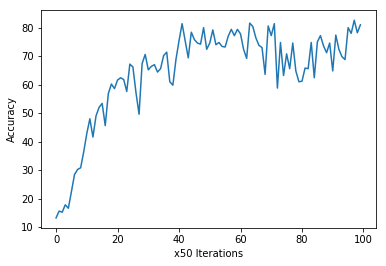

In [18]:
plt.plot(list(range(epoch_50)),acc_list) # 50 epoch counting variable
plt.xlabel("x50 Iterations")
plt.ylabel("Accuracy")

In [19]:
accuracy()

Accuracy is now 76.00  %


468
True
7 7


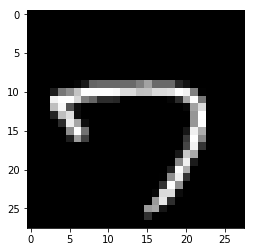

In [20]:
c = int(input())
zx,zy = predict(c)
if (zx==zy):
    print("True")
else:
    print("False")
print(zx,zy)
plt.imshow(x_data_Scaled[:,c].reshape((28,28)),cmap='gray')

Weight 0-9: 5
Enter slice 0-4: 2


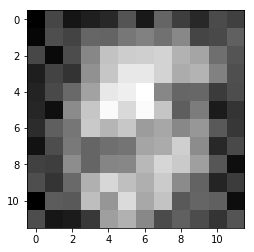

In [22]:
#To Visualize Weight Matrix of FC layer
sa = int(input("Weight 0-9: "))
ss = int(input("Enter slice 0-4: "))
plt.imshow(w[sa,:,ss].reshape(12,12),cmap='gray')

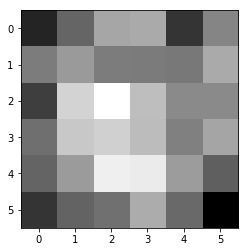

In [23]:
plt.imshow(f_1_1,cmap='gray')

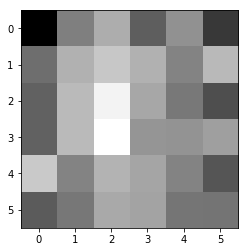

In [24]:
plt.imshow(f_1_3,cmap='gray')